# <font color='blue'>COMP41680 Assignment 2: Text Scraping & Clustering</font>
# Shivansh Bhandari (16204820)
# Part 2: Corpus Exploration



Import all the required packages to do the Analysis

In [1]:
import nltk
import pandas as pd
import operator
import numpy as np
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

## <font color='blue'> Loading and Analysis of the Corpus </font>

The text data from the all the articles present in the URL http://mlg.ucd.ie/modules/COMP41680/news/index.html is collected and the analysed to get the basic structure of the resultant corpus.

The following code gives us the basic structure of the corpus i.e the number of documents and the number of unique terms or the features, before performing any preprocessing step on the corpus. 

In [2]:
#Open the .txt file in read mode.
fin = open("Articles_Text.txt","r")
#Read the corpus line wise. Thus, a new line in the corpus would mean the start of a new document
raw_documents = fin.readlines()
fin.close()
vectorizer = CountVectorizer()
# Use the countvectorizer to corvert the corpus in (n_samples,n_features) matrix format.
X = vectorizer.fit_transform(raw_documents)
print("The corpus contains %d documents" % X.shape[0])
print()
print("The corpus contains %d unique terms i.e. features"%X.shape[1])


The corpus contains 1131 documents

The corpus contains 21462 unique terms i.e. features


## <font color='blue'> Task 1: Preprocessing and Constructing the Document-term matrix</font> 

To following preprocessing steps were used to process text input files to reduce the number of terms used to represent the text and to improve the resulting bag-of-words model, it is basically cleaning up the corpus and keeping only the important terms in the corpus.

Tokkenization and Normalization: Raw text documents are textual, not numeric. To analyse unstructured documents, it is essential to split the raw text into individual tokens, each corresponding to a single term (word). All the wors in the corpus were converted to lowercase and scikit-learn tokenizer was used to tokenize the text.

Lemmatisation: This is used to reduce the terms to its cononical form, in this endings are removed from terms in order to remove things like tense or plurals: e.g. compute, computing, computer = comput. This is a more advanced form of stemming, only removes affixes if the resultant word in present in the dictionary. WordNetLemmatizer() from NLTK package is used to lemmatize the words in the corpus.

Stop-word Removal: Remove terms that appear on a pre-defined "blacklist" of terms that are highly frequent and do not convey useful information (e.g. and, the, while). The countVectorizer was used to remove the stop words using the built-in list of stop-words.

Low frequency filtering: Removing the terms that appear in very few documents. The terms whcih appeared in less than 4 documents was removed.


In [3]:
# Method to perform tokkenization, normalization and lemmatization on the corpus
def lemma_tokenizer(text):
    # The standard scikit-learn tokenizer 
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text.lower())
    # WordNetLemmatizer to lemmatize the words in the corpus
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma_tokens = []
    for token in tokens:
        lemma_tokens.append( lemmatizer.lemmatize(token) )
    return lemma_tokens

CountVectorizer applies the preprocessing steps on the corpus using built-in functions and some user defined methods and produes a matrix in form of (n_samples,n_fetaures) i.e. document term matrix. The count vectorizer converts the corpus to a matrix of token counts. It basically reurns the frquency of each word in a document in a form of matrix.


In [4]:
# Countvectorizer would remove the stop words, words which appeear in less than 2% of documents, maximum document 
#frequency was set at 20%, ngram range was set at 3 and uses the lemma_tokenizer method to preprocess the text.
count_vectorizer = CountVectorizer(stop_words="english",min_df=0.02,max_df=0.2,tokenizer=lemma_tokenizer,ngram_range=(1,3))
#fit_transform learns the vocabulary dictionary and return term-document matrix.
data_count = count_vectorizer.fit_transform(raw_documents)
# store the output from the above step in pandas to represent it as document term matrix.
doc_term_matrix= pd.DataFrame(data_count.toarray(), columns=count_vectorizer.get_feature_names())
#Prints the shape of resultant matrix
print(data_count.shape)
#Prints the document term matrix of documents in index range of 100 to 110 and words in index range of 700 to 715.
doc_term_matrix.ix[100:110,300:315]

(1131, 1779)


,chief,chief executive,child,child hospital,china,chip,choice,choose,christmas,circumstance,city,claim,claimed,claiming,clean
100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
101,0,0,18,0,0,0,0,0,0,0,0,0,0,0,0
102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
103,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0
104,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
107,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
109,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Tf-idf stands for term frequency-inverse document frequency which is used to evaluate how important a word is to a document in a collection or corpus. Term Frequency is the proportion of occurrences of a specific term to total number of terms in a document and inverse document frequency is the inverse of the proportion of documents that contain that word/phrase. The general idea behind Tf-IDF is that if a specific phrase appears a lot of times in a given document, but it doesn’t appear in many other documents, then that phrase is important in distinguishing that document from all the others.


TfidfVectorizer can perform the same preprocessing steps as countvectorizer on the text and produes a matrix in form of (n_samples,n_fetaures) i.e. document term matrix. The TfidfVectorizer converts the corpus to a matrix of TF-IDF features. 

In [5]:
#TfidfVectorizer would remove the stop words, words which appeear in less than 2% of documents, maximum document 
#frequency was set at 20%, ngram range was set at 3 and uses the lemma_tokenizer method to preprocess the text.
tvectorizer = TfidfVectorizer(stop_words="english",min_df=0.02,max_df=0.2,tokenizer=lemma_tokenizer,ngram_range=(1,3))
#fit_transform learns the vocabulary dictionary and return term-document matrix.
data_tfidf = tvectorizer.fit_transform(raw_documents)
#store the output from the above step in pandas to represent it as document term matrix.
doc_term_matrix_tfidf = pd.DataFrame(data_tfidf.toarray(), columns=tvectorizer.get_feature_names())
#Prints the shape of resultant matrix
print(data_tfidf.shape)
#Prints the document term matrix with TF-IDF weights words in index range of 700 to 715 
doc_term_matrix_tfidf.ix[100:110,300:315]

(1131, 1779)


,chief,chief executive,child,child hospital,china,chip,choice,choose,christmas,circumstance,city,claim,claimed,claiming,clean
100,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
101,0.0,0.0,0.524024,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
102,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
103,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.111889,0.0,0.0,0.258281,0.0,0.0,0.000000,0.0
104,0.0,0.0,0.109382,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
105,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
106,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
107,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.141871,0.0
108,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
109,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0



The <font color='red'>max_df</font> is the maximum number of documents a term should come in i.e. those terms are removed whihc have higher document frequency then the set threshold frequency. Earlier it was set at 0.9, but, terms like "said" appeared in top 20 words when ranked according to average of tf-idf score. Thus, to remove words like "said" which do not convey any meaning and are not stop-words the value of max_df was set at 0.2. Thus, the terms which appeared in more than 20% of the documentsbwas removed. 

The <font color='red'>ngram_range</font> was set at 3 i.e. maximum of 3 terms which comes together and are important to a document would be considered.

The <font color='red'>min_df</font> value was changed to 4, 5, 6, 0.01, 0.02, 0.03, 0.04 and the sparsity of the matrix was calculated. Even though the sparsity was reduced, there still were enough terms to from clusters in the matrix. Thus, the min_df was set at 0.02 i.e. only those terms or phrases would be considered whihc comes in more than 2% of the documents.

In [6]:
print ('sparsity: %.2f%%' % (100-(100.0 * data_tfidf.nnz / (data_tfidf.shape[0] * data_tfidf.shape[1]))))

sparsity: 94.74%


The matrix generated from the TF-IDF vectorization is a sparse matrix i.e. most of the values in the matrix are null. There are sveral probles whihc arise due to sparsity during text analytics like:


Additional memory and processing requirements due to more dimensions (terms) and analytical problems related to sparsity - example when using a bag-of-words representation, we can fail to identify documents which are related to the same concepts.

Thus, lesser the sparsity, better the performance and analysis. The sparsity can be reduced by selestcing the rigth value of minimum document frquency and maximum document frequency of a word during the vectorization, in this way those words which are not occuring in minmum number of documents and which are occuring in more than the defined threshold would be removed and the result would be lesser number of features in the matrix.


## <font color='blue'>Task 2: Identifying the most characteristic terms and phrases</font>

The most characteristic terms in a corpus can be found out either using the count i.e. there frequency in the corpus or by there average TF-IDf score. The terms that appears most in a corpus tends to point towards the topic or context of the corpus. 

Both the measures gives the basic idea about the corpus and the corpus can be summarised using the terms obtained by sorting the terms based on there sum of occurences in the corpus or there average TF-IDF score. 

## Most Characteristic terms based on there frequency

In [7]:
#Add the number of times the term has occured in the corpus and store it in a list
count = np.asarray(data_count.sum(axis=0)).ravel().tolist()
#Store the features and there count into a dataframe
counts_df = pd.DataFrame({'term': count_vectorizer.get_feature_names(), 'Count': count})
#Sort the count_df in descending order and display the top 50 terms in the dataframe.
counts_df.sort_values(by='Count', ascending=False).head(40)

,Count,term
766,941,health
797,859,hospital
1608,704,tax
193,577,bank
1613,518,technology
804,479,hse
302,471,child
1056,457,mobile
1047,452,minister
530,452,economy


## Most characteristic terms based on there average TF-IDF score

In [8]:
#Calculate the mean of the TF-IDF score of a term and store it in a list
weights = np.asarray(data_tfidf.mean(axis=0)).ravel().tolist()
#Store the features and aclculated mean into a dataframe
weights_df = pd.DataFrame({'term': tvectorizer.get_feature_names(), 'weight': weights})
#Sort the weights_df in descending order and display the top 50 terms in the dataframe.
weights_df.sort_values(by='weight', ascending=False).head(40)

,term,weight
797,hospital,0.026983
766,health,0.026072
1608,tax,0.024394
193,bank,0.020438
327,club,0.019622
804,hse,0.017395
302,child,0.016907
1056,mobile,0.016700
1613,technology,0.016400
530,economy,0.016167


## Most characteristic phrases based on there frequency

In [9]:
# Using the count vectorizer with ngram_range set as (2,3) to find the most characteristic phrsses in the text bases on frequency
count_vectorizer_n = CountVectorizer(stop_words="english",min_df=0.02,max_df=0.2,tokenizer=lemma_tokenizer,ngram_range=(2,3))
#fit_transform learns the vocabulary dictionary and return term-document matrix.
data_count_n = count_vectorizer_n.fit_transform(raw_documents)
#Add the number of times the phrase has occured in the corpus and store it in a list
count_n = np.asarray(data_count_n.sum(axis=0)).ravel().tolist()
#Store the features and there count into a dataframe
counts_df_n = pd.DataFrame({'term': count_vectorizer_n.get_feature_names(), 'Count': count_n})
#Sort the count_df in descending order and display the top 20 phrases in the dataframe.
counts_df_n.sort_values(by='Count', ascending=False).head(20)

,Count,term
139,203,said mr
22,196,chief executive
143,176,said wa
42,158,euro zone
58,147,good faith
129,147,report content
116,146,offending comment filling
25,146,clicking flag link
26,146,comment filling
27,146,comment filling form


## Most Characteristic Phrases using average TF-IDF score

In [10]:
#Using the TF-IDF vectorizer with ngram_range set as (2,3) to find the most characteristic phrsses in the text bases on TF-IDF score
tfvectorizer = TfidfVectorizer(stop_words="english",min_df=0.02,max_df=0.2,tokenizer=lemma_tokenizer,ngram_range=(2,3))
#fit_transform learns the vocabulary dictionary and return term-document matrix.
data_tfidf_n = tfvectorizer.fit_transform(raw_documents)
#Calculate the mean of the TF-IDF score of a phrase and store it in a list
weights_n = np.asarray(data_tfidf_n.mean(axis=0)).ravel().tolist()
#Store the features and calculated mean into a dataframe
weights_df_n = pd.DataFrame({'term': tfvectorizer.get_feature_names(), 'weight': weights_n})
#Sort the weights_df in descending order and display the top 50 terms in the dataframe.
weights_df_n.sort_values(by='weight', ascending=False).head(20)

,term,weight
139,said mr,0.046881
167,year old,0.042435
22,chief executive,0.037066
143,said wa,0.036557
103,mobile phone,0.031143
91,manchester united,0.030450
21,champion league,0.029170
61,ha said,0.027449
155,told online,0.025854
156,told online news,0.025772


## Inference based on most characteristic terms and phrases

After ranking the terms and phrases based on there number of occurences in the corpus and there average TF-IDF scores, it can be inferred that

Due to occurence of words like cent, bank, million, economy, tax etc. and phrases like central bank, cent year etc. the documents are about <font color='red'>"Economy"</font>

Due to occurence of words like player, game etc. and phrases like manchester united etc. the documents are about <font color='red'>"Sports"</font>

Due to occurence of words like mobile, technology, phone etc. and phrases like mobile phone etc. the documents are about <font color='red'>"Technology"</font>

Due to occurence of words like government, european, minister etc. the documents are about <font color='red'>"Politics"</font>

Due to occurence of words like hospital, health etc. and phrases like health service etc. the documents are about <font color='red'>"Health"</font>

So, based on the frequency and there average TF-IDF score of the terms and phrases, the corpus contains documents related to 5 topics i.e. it could generate <font color='red'>5 clusters.</font>

## <font color='blue'>Task 3: Clustering</font>

Clustering is an unsupervised machine learning task, where an algorithm is used to organise data into groups in the absence of any external information (e.g. class labels), only relying on the data itself (e.g. feature values and often some similarity/distance value computed on those features).

Partitional clustering: Algorithms which attempt to directly decompose a data set into a “flat” grouping consisting of a number of disjoint (non-overlapping) clusters. Usually pre-specify number of clusters *k*. The partitional algorith used is K-means, the algorithm involves randomly selecting K initial centroids, where K is a user defined number of desired clusters. Each point is then assigned to a closest centroid and the collection of points close to a centroid form a cluster. The centroid gets updated according to the points in the cluster and this process continues until the points stop changing their clusters.

Agglomerative algorithms start with each item assigned to its own cluster, and then apply a bottom-up strategy where, at each step, the most similar (least distant) pair of clusters are merged. We continue until we reach a specified number of clusters or until every item is in a single cluster. 

### Principal Component Analysis (PCA)

Principal Component Analysis is a linear dimensionality reduction technique which performs a linear mapping of the data to a lower-dimensional space in such a way that the variance of the data in the low-dimensional representation is maximized. The dimensionality reduction is about converting data of very high dimensionality into data of much lower dimensionality such that each of the lower dimensions convey much more information. When Bag of Words representaion is used, each of the sentences gets represented in a high dimensional space of length equal to the vocabulary. To represent this in 2D it is required to reduce the dimension.




In [11]:
#todense() returns the dense matrix representation a matrix
dense_data_tfidf=data_tfidf.todense()
#principal component analysis on the dense matrix
pca = PCA().fit(dense_data_tfidf)

### K-Means Algorithm

As inferred in the last section from the most characteristic terms that the corpus could have documents related to 5 topics, which should lead to 5 clusters whena clustering algorithm is applied. So, the K-means algorithm was applied for the value of k as 3,4,5 and 6 and the clusters obtained were observed.

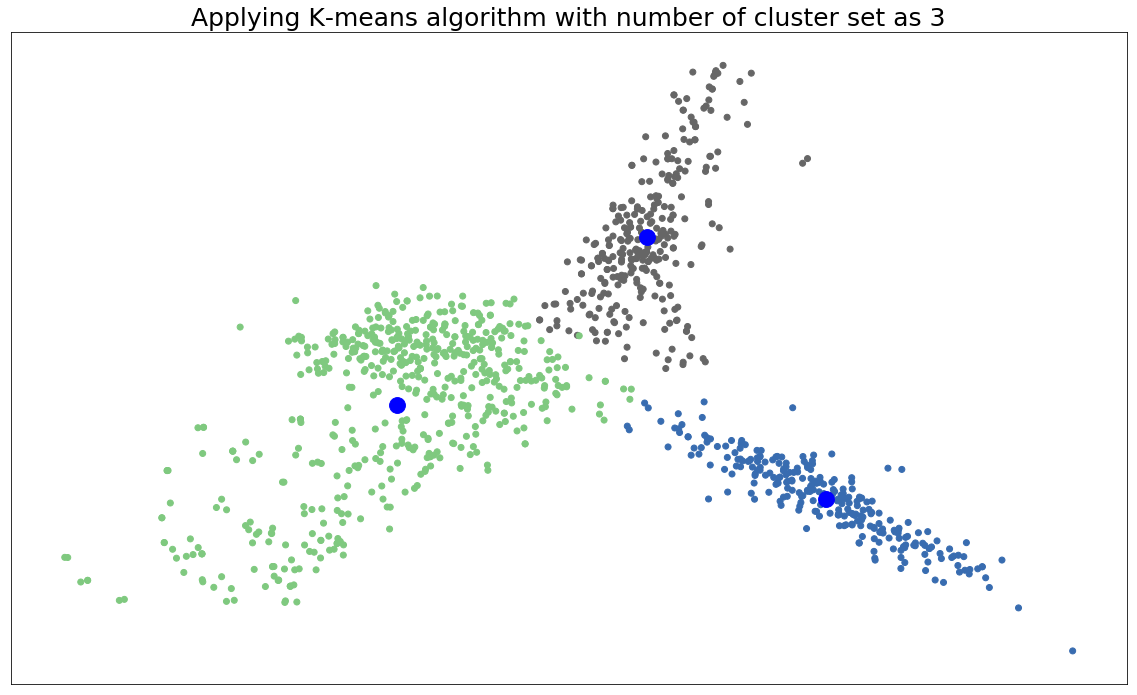

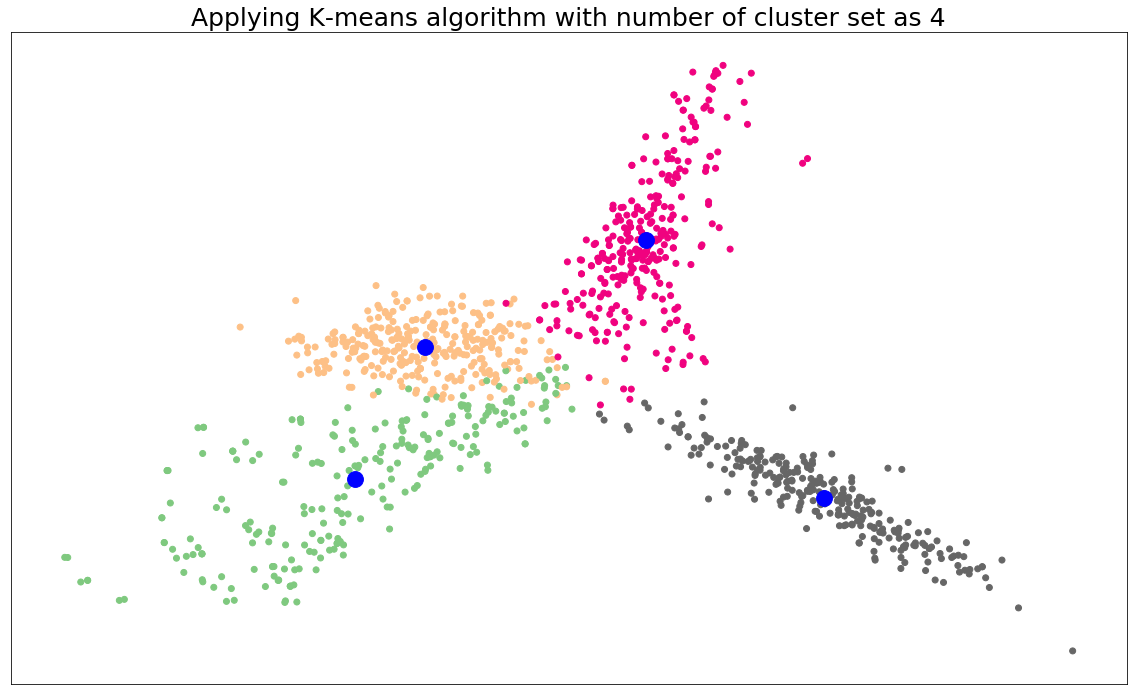

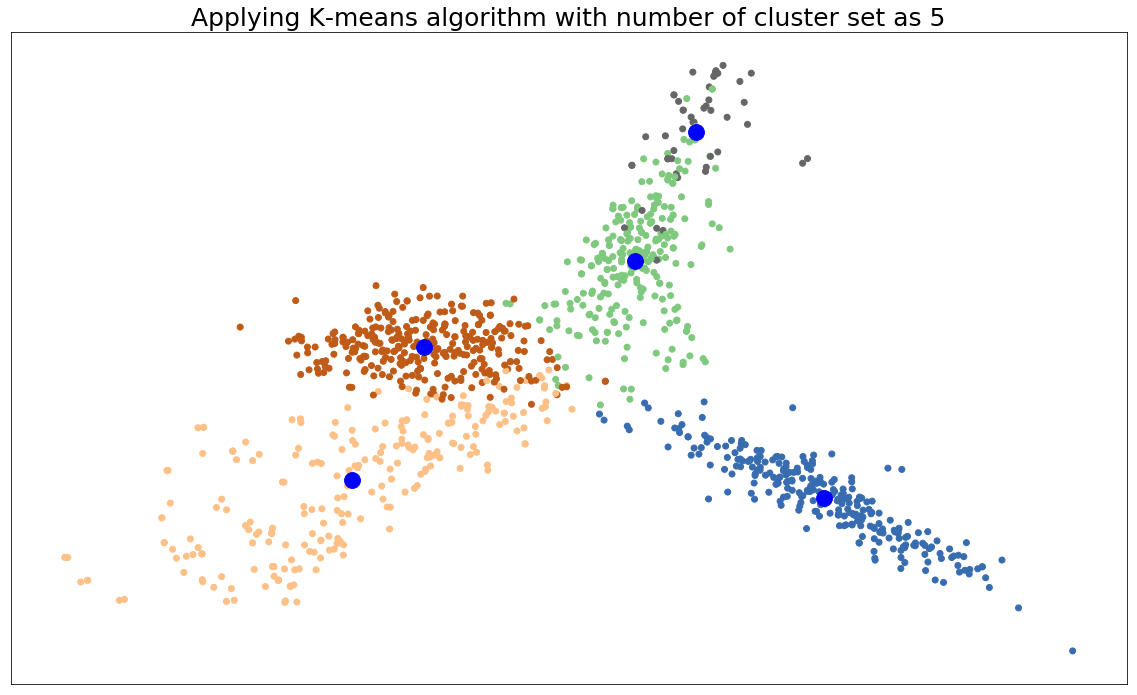

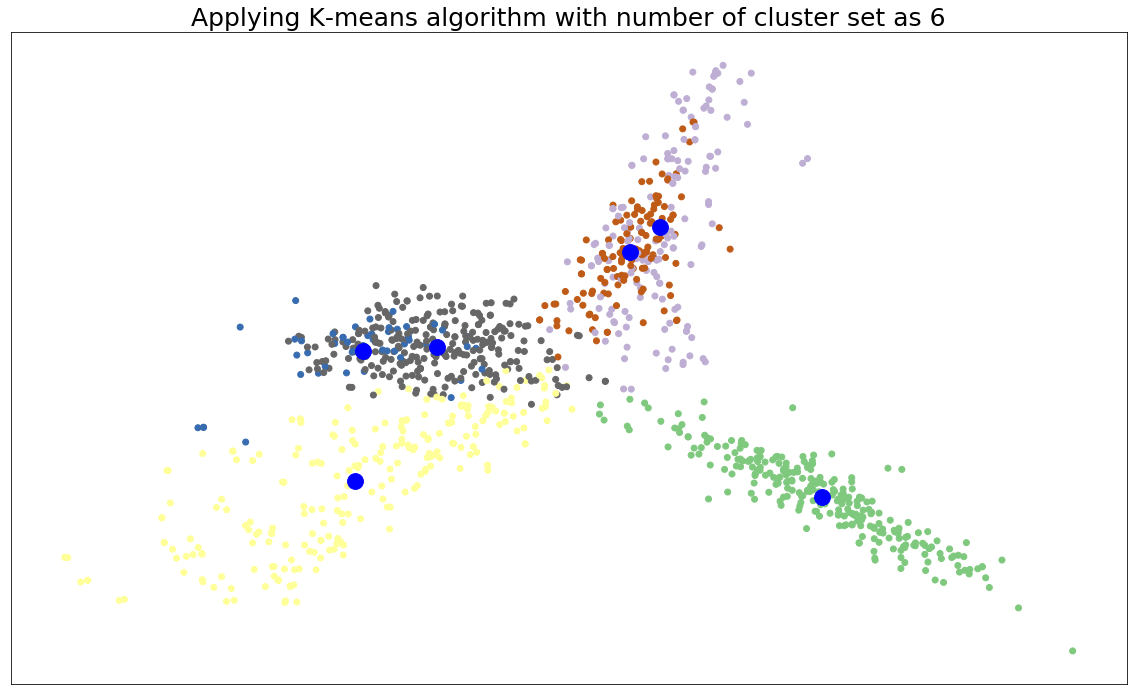

In [12]:
#Different values to be considered for the value of k
n_clusters=[3,4,5,6]
for i in n_clusters:
    plt.figure(figsize=(20,12))
    #apply k-means clustering with n_clusters defined by i, the staring seeds selected in a smart way by setting 
    #init as k-means++ and the number of time the k-means algorithm will be run with different centroid seeds. The 
    #final results will be the best output of n_init consecutive runs.
    kmeans = KMeans(n_clusters=i,init='k-means++',n_init=10).fit(dense_data_tfidf)
    # find the cluster centers 
    cluster_centers = pca.transform(kmeans.cluster_centers_)
    # apply PCA to the data
    plotting_data = pca.transform(dense_data_tfidf)
    #returns the labels of each point, which will be used to assign colors to different clusters
    clustering = kmeans.labels_
    #Set the title of the plot
    plt.title("Applying K-means algorithm with number of cluster set as %d" %i, fontsize=25)
    #plot the data
    plt.scatter(plotting_data[:,0], plotting_data[:,1],c=clustering,cmap='Accent')
    #plot the cluster centers
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='o', s=250, c='b')
    # remove the ticks and labels from the x-axis
    plt.tick_params(axis= 'x', bottom='off', labelbottom='off')
    # remove the ticks and labels from the y-axis 
    plt.tick_params(axis= 'y', left='off', labelleft='off')
    plt.show()              


<font color='red'>It can be inferred from the above plots that, the most distinct clusters are formed when the k is set at 4</font>

## Hierarchical Clustering

Hierarchical clustering applies bottum-up approach where each item assigned to its own cluster and at each step, the most similar (least distant) pair of clusters are merged. This is continued until specified number of clusters are formed or until every item is in a single cluster.

To compute the distance between each pair of items, a distance metric is required and scipy hierarchy package provides a number of methods to calculate the distance example-Euclidean, cosine, amnhattan etc. and different criteria exist for choosing which pair of clusters to merge at each step - the linkage metric example- single, complete, average, mean, ward etc.




<font color='green'>Different method and metric pairs like single with euclidean, average with euclidean, single with cosine, mean with euclidean etc. were applied but, none of them gave well defined clusters as output. Example of execution of one of the pair is shown below.</font>

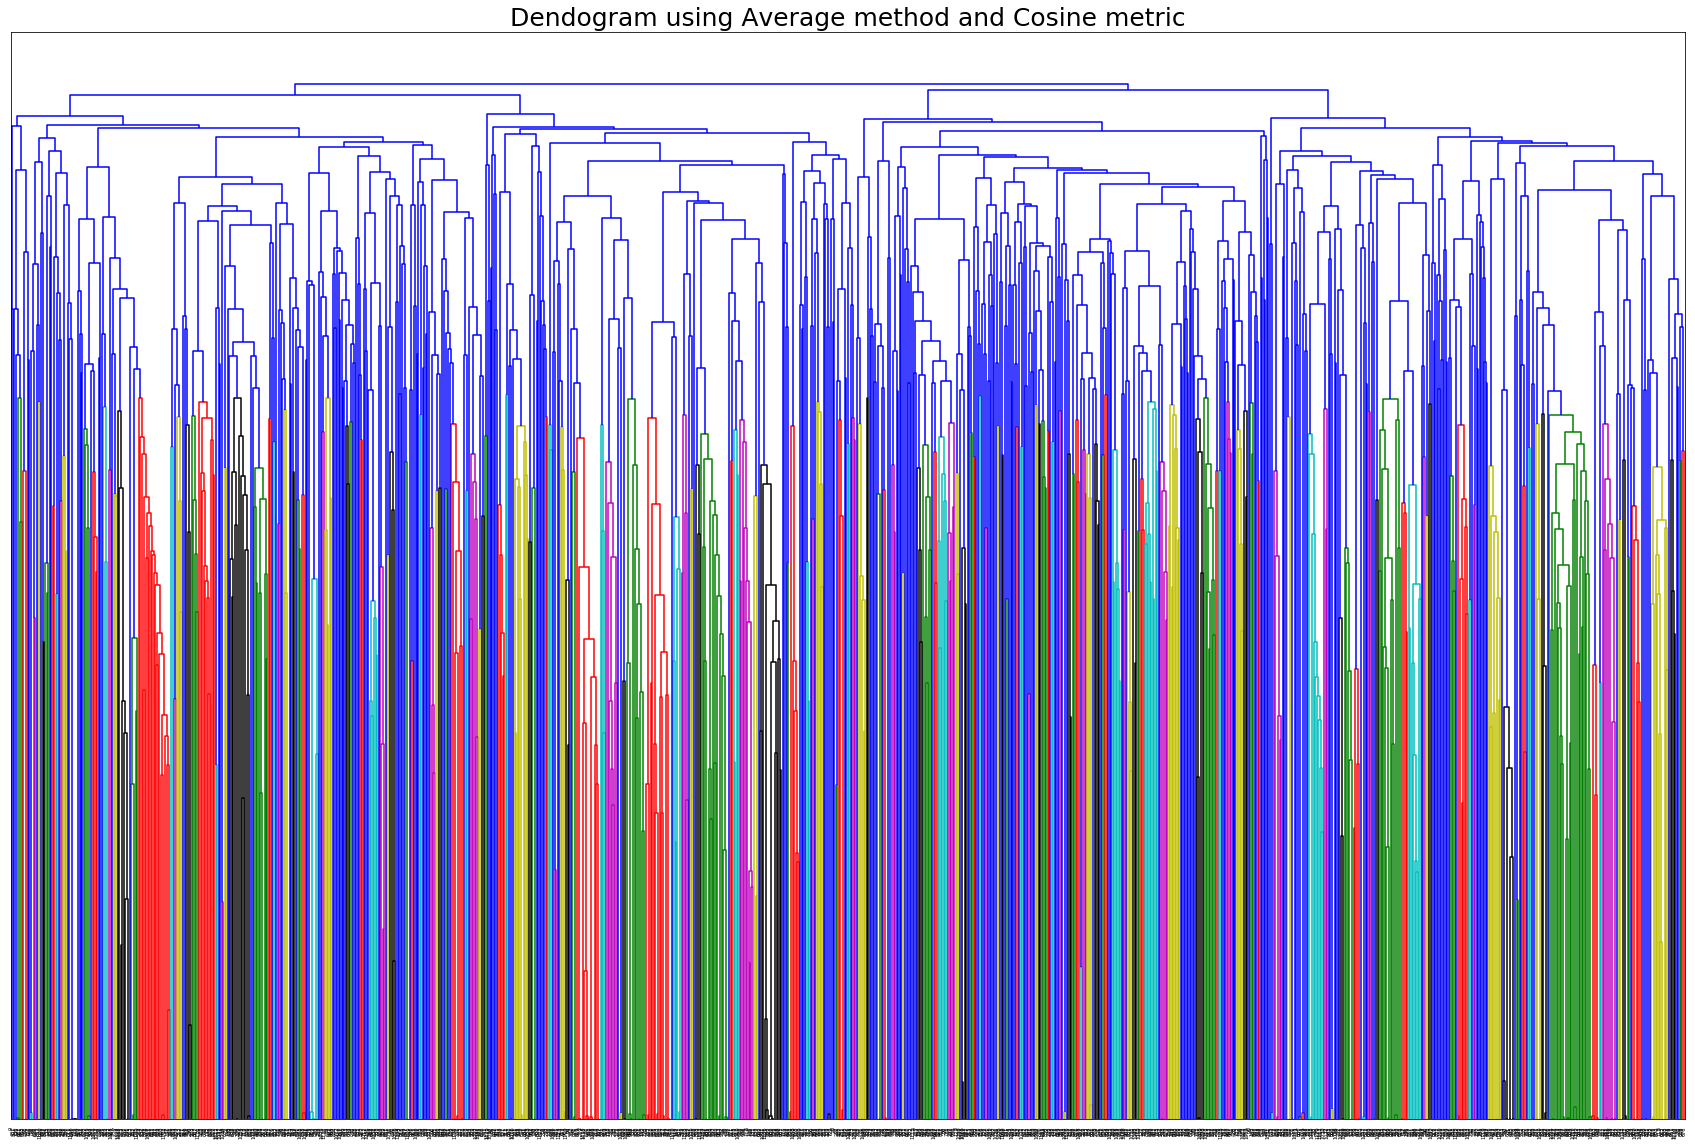

In [13]:
#Performs hierarchical clustering,creates the tree
tree1 = hac.linkage(plotting_data, method="average", metric="cosine")
plt.figure(figsize=(30,20))
#remove the ticks and labels from the y-axis 
plt.tick_params(axis= 'y', left='off', labelleft='off')
plt.title("Dendogram using Average method and Cosine metric",fontsize=25)
#Visualize the tree as dendogram
hac.dendrogram(tree1)
plt.show()

<font color='red'>There are no definite clusters generated applying the hierarchical clustering with method set as average and metric set as cosine.</font> 


But, Definite clusters were produced when Ward method was used. The ward method uses the Ward variance minimization algorithm whih uses Euclidean distance as metric to find the closest element. Ward method tends to look for spherical clusters, very cohesive inside and extremely differentiated from other groups. Another characteristic is that the method tends to find clusters of similar size.

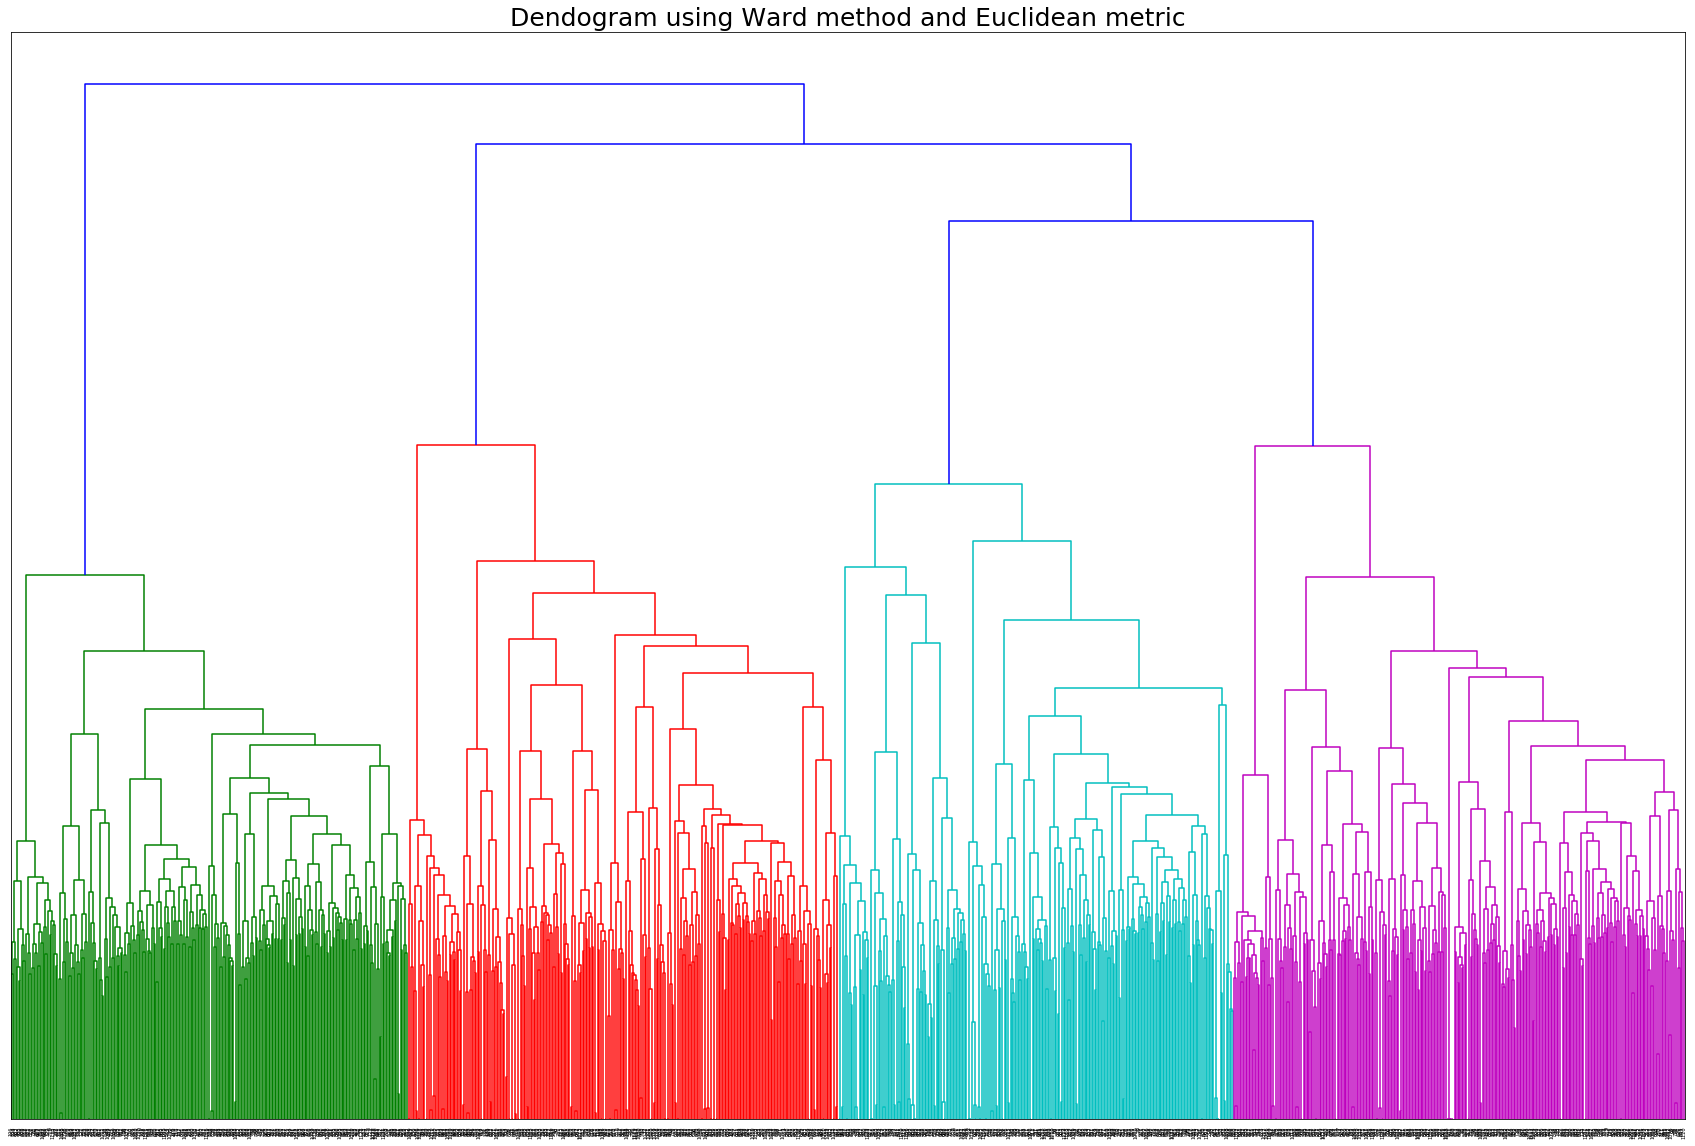

In [14]:
#Performs hierarchical clustering,creates the tree.
tree2 = hac.linkage(plotting_data, method="ward", metric="euclidean")
plt.figure(figsize=(30,20))
#remove the ticks and labels from the y-axis 
plt.tick_params(axis= 'y', left='off', labelleft='off')
plt.title("Dendogram using Ward method and Euclidean metric",fontsize=25)
#Visualize the tree as dendogram
hac.dendrogram(tree2)
plt.show()

<font color='red'>There are 4 disitinct clusters produced when Ward method with metric set as Euclidean was used.</font>

Truncation is used to condense the dendrogram. In the following graph truncate_mode is used in last_p mode in which the last p non-singleton formed in the linkage are the only non-leaf nodes in the linkage. The value of p is set at 40 which will be used by the truncate_mode.

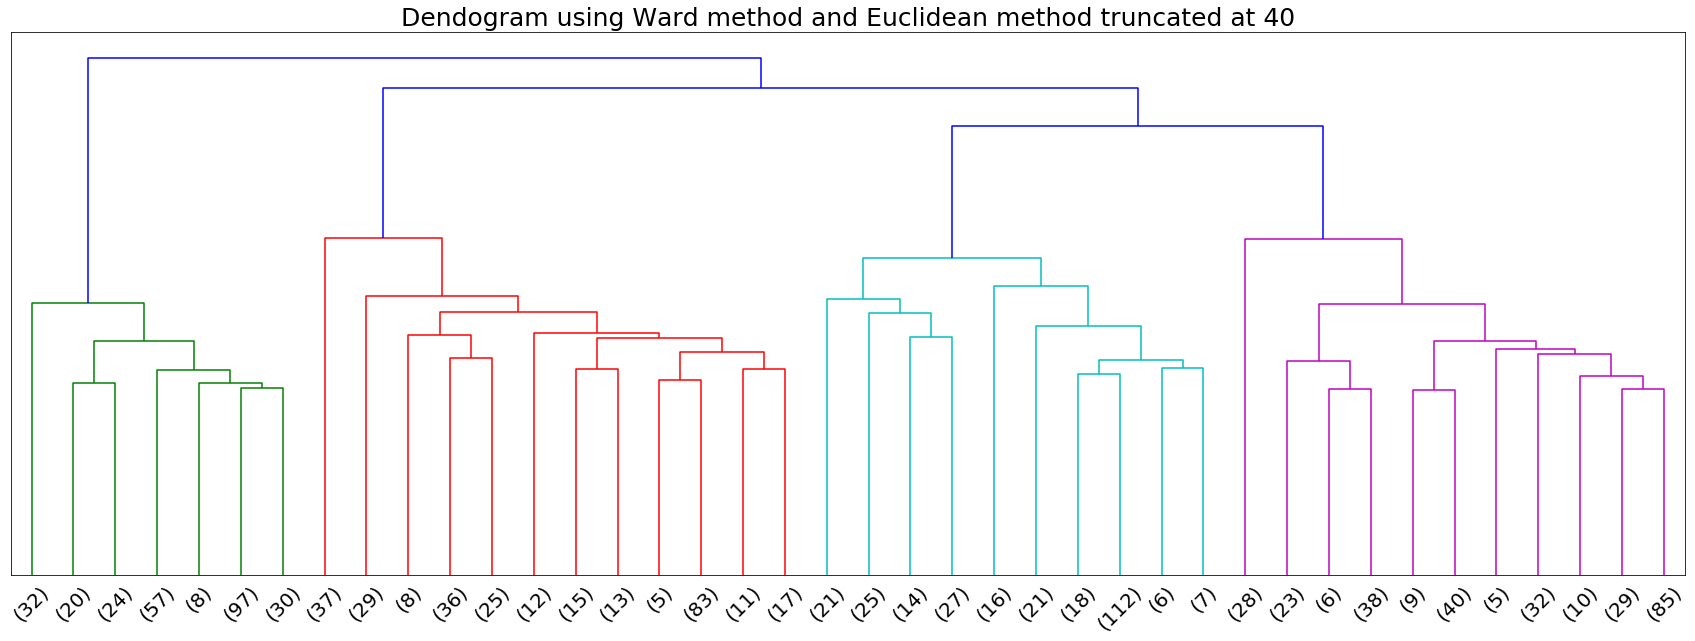

In [15]:
plt.figure(figsize=(30,10))
#remove the ticks and labels from the y-axis 
plt.tick_params(axis= 'y', left='off', labelleft='off')
#Visualize the tree as dendogram, truncate condenses the dendogram.
hac.dendrogram(tree2,truncate_mode='lastp',p=40,leaf_font_size=20)
plt.title("Dendogram using Ward method and Euclidean method truncated at 40",fontsize=25)
plt.show()

<font color='green'>The dendogram with labels associated to its feature names is represented below.</font>

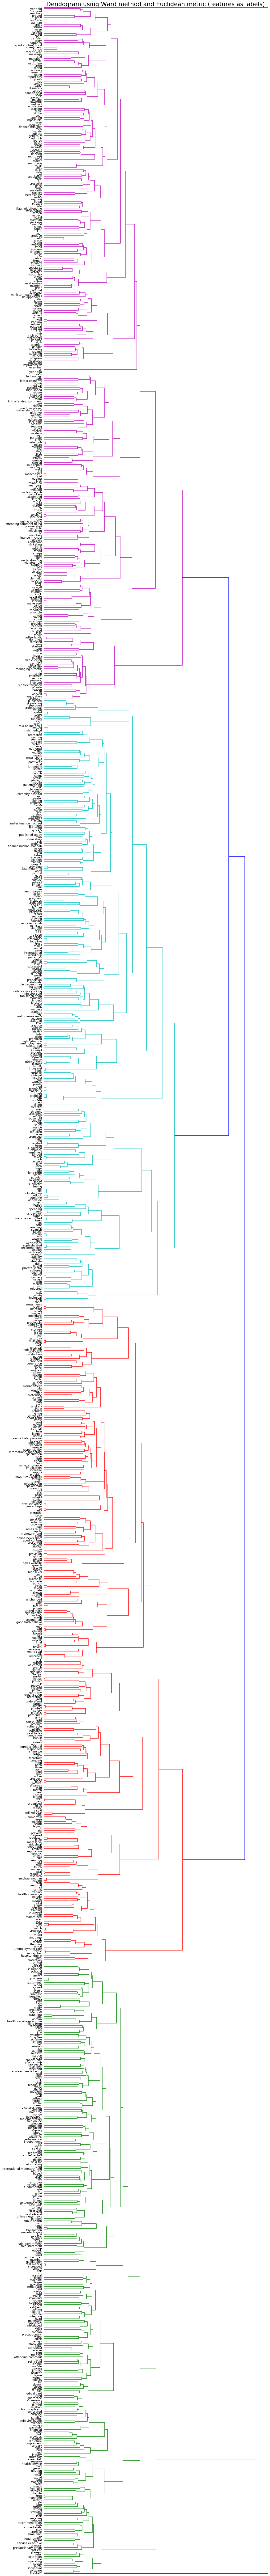

In [16]:
plt.figure(figsize=(17,200))
# get the feature names associated with the index
label=tvectorizer.get_feature_names()
# Visualize the dendogram
hac.dendrogram(tree2,orientation='right',labels=label,leaf_font_size=12)
# remove the ticks and labels from the x-axis
plt.tick_params(axis= 'x', bottom='off', labelbottom='off')
plt.title("Dendogram using Ward method and Euclidean metric (features as labels)",fontsize=25)
plt.show()

<font color='green'>The tree can also be cut-off at a point to produce a flat clustering. The cut off was set at 2,3,4,5 and 6 and the clusters were observed.</font>

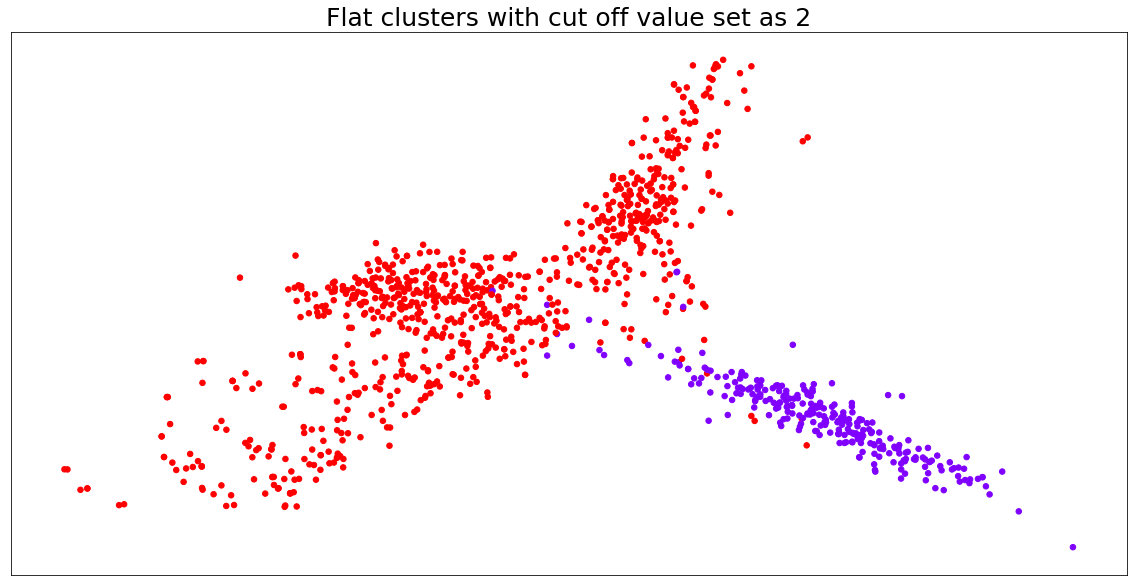

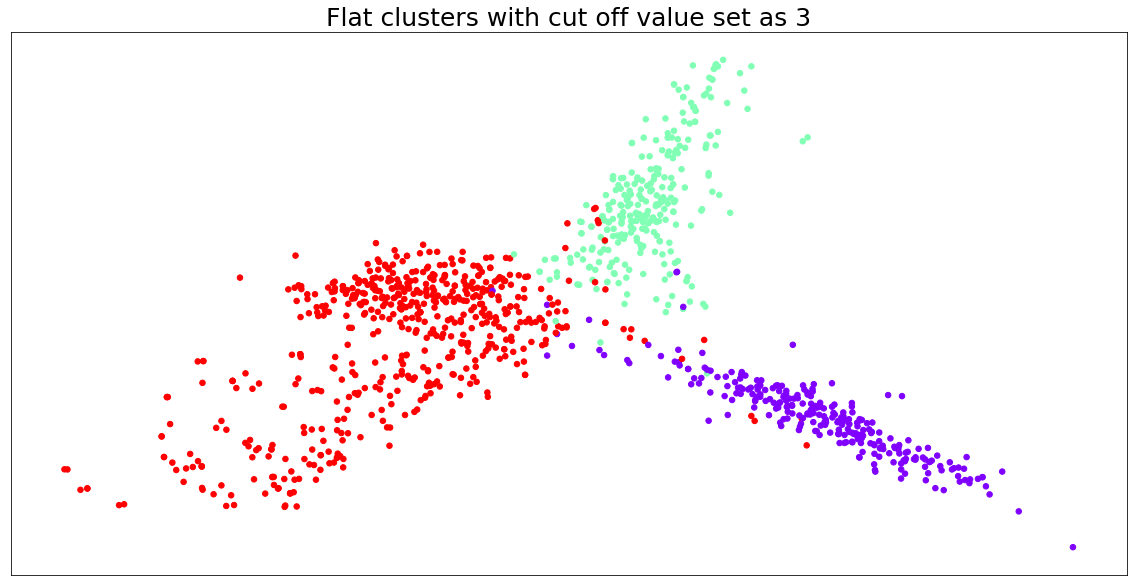

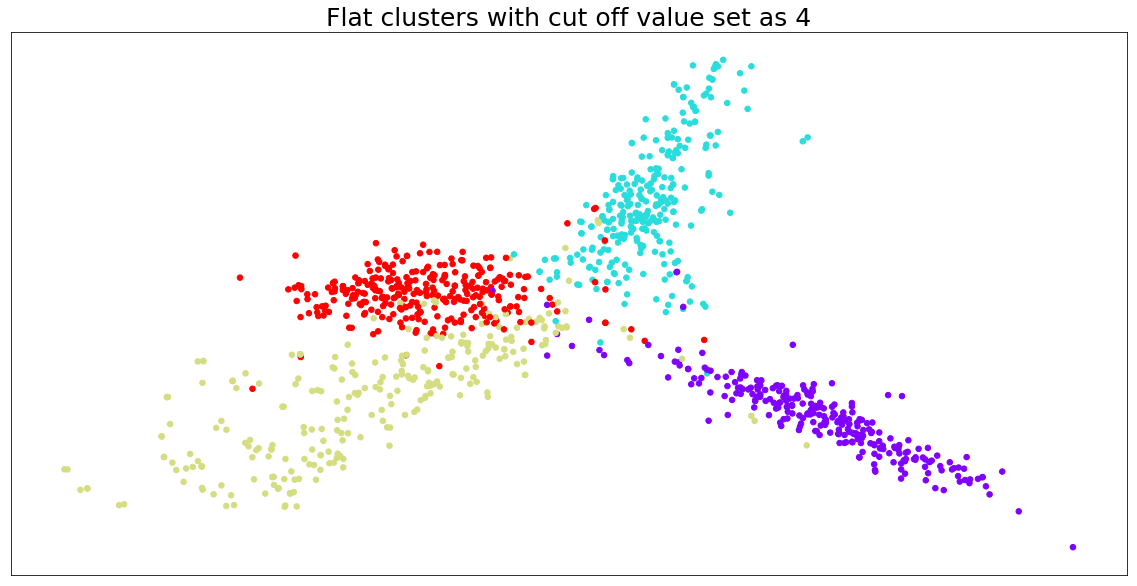

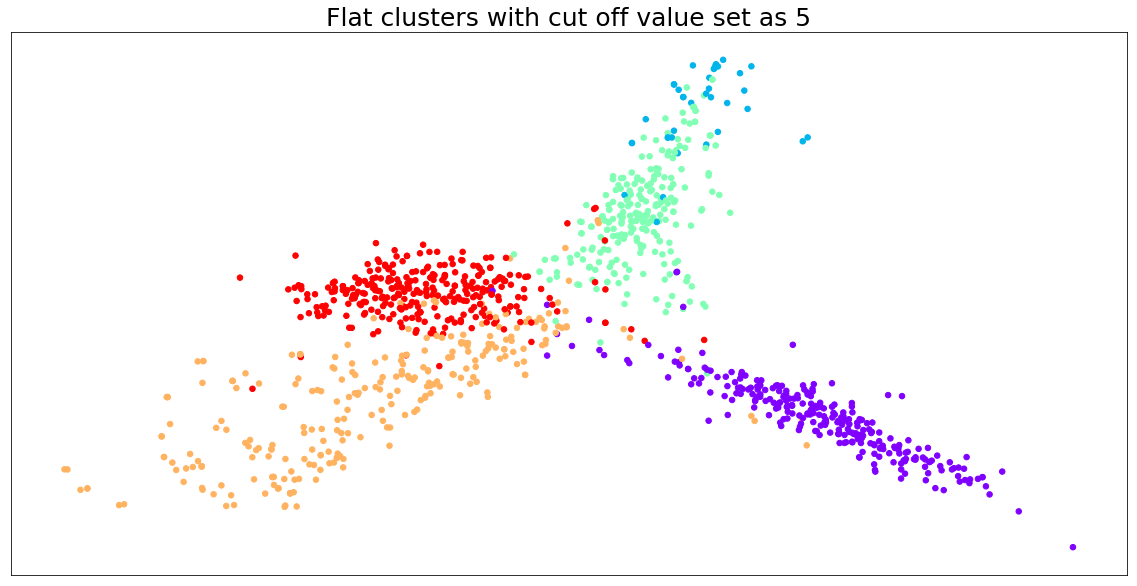

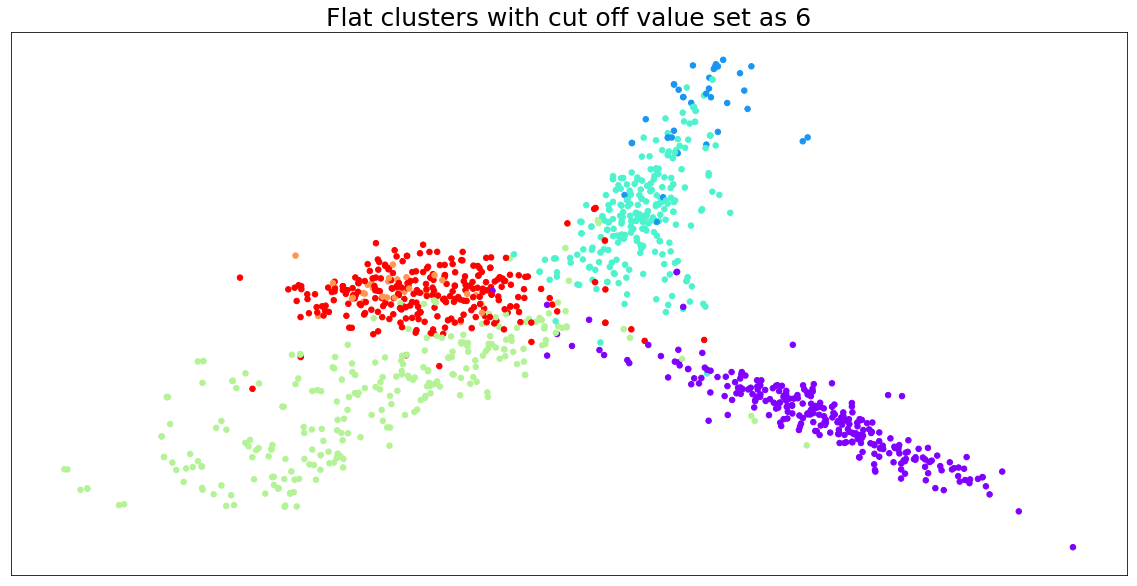

In [17]:
from scipy.cluster.hierarchy import fcluster
# Create a list containing the cut off values
cut_off_val=[2,3,4,5,6]
for val in cut_off_val:
    #Form flat clusters from the hierarchical clustering from linkage matrix tree 
    clustering = fcluster(tree2,val,'maxclust')
    #The size of the plot
    plt.figure(figsize=(20,10))
    #remove the ticks and labels from the x-axis 
    plt.tick_params(axis= 'x', bottom='off', labelbottom='off')
    # remove the ticks and labels from the y-axis 
    plt.tick_params(axis= 'y', left='off', labelleft='off')
    #Plot the data
    plt.scatter(plotting_data[:,0],plotting_data[:,1],c=clustering,s=30,cmap='rainbow')
    #Set the title of the plots
    plt.title("Flat clusters with cut off value set as %d" %val, fontsize=25)
    plt.show()

<font color='red'>It can be inferred from the above plots that, the most distinct clusters are formed when the cut off is set at 4</font>


## <font color='blue'>Task 4: Conclusion</font>

<font color='green'>From both the clustering algorithm applied in the above task, it can be inferred that the corpus contains documents of 4 major topics or has 4 clusters. The content in each cluster can be used to provide a topic to the documents that are similar to each other. The top terms in each cluster are: </font>

In [18]:
print("Top terms in each cluster are:")
order_centroids_t = kmeans.cluster_centers_.argsort()[:, ::-1]
terms_t = tvectorizer.get_feature_names()
for i in range(4):
    print ("Cluster %s:" % str(i+1))
    for ind in order_centroids_t[i, :20]:
        print (' %s' % terms_t[ind],)
    print()

Top terms in each cluster are:
Cluster 1:
 club
 chelsea
 goal
 united
 arsenal
 league
 cup
 football
 team
 win
 liverpool
 manager
 play
 season
 match
 bos
 minute
 premiership
 manchester
 england

Cluster 2:
 mobile
 phone
 technology
 digital
 tv
 music
 gadget
 broadband
 video
 device
 uk
 consumer
 sony
 dvd
 gaming
 speed
 medium
 console
 2005
 network

Cluster 3:
 hospital
 health
 hse
 child
 patient
 medical
 doctor
 dr
 care
 reilly
 death
 public
 maternity
 consultant
 halappanavar
 department
 woman
 cancer
 executive
 m

Cluster 4:
 tax
 billion
 property
 revenue
 budget
 income
 noonan
 finance
 target
 relief
 exchequer
 pension
 payment
 measure
 minister
 international
 mr noonan
 corporation
 pay
 tax rate



## Theme of Each Document

=>Due to the presence of the words like Economy, Economic, Billion, Million, Investment etc, it can be concluded that the documents in cluster are about a common topic i.e. <font color='red'> Finance or Economic</font>. All the documents in that cluster come under the category of Finance or Economics.

=>Due to the presence of the words like hospital, health, child, care etc, it can be concluded that the documents in cluster are about a common topic i.e. <font color='red'> Heatlh</font>. All the documents in that cluster come under the category of Health.

=>Due to the presence of the words like phone, technology, mobile etc, it can be concluded that the documents in cluster are about a common topic i.e. <font color='red'>Technology</font>. All the documents in that cluster come under the category of Technology.

=>Due to the presence of the words like football, arsenal, chelsea, liverpool etc, it can be concluded that the documents in cluster are about a common topic i.e. <font color='red'>Football</font>. All the documents in that cluster come under the category of Football.

Even though in the task 2 it was concluded after analyzing the most characteristic terms and phrases based on frequency or there average tf-idf score that the corpus contains the documents of 5 themes. But, after applying the clustering algorithms and analyzing the data in each cluster it can be concluded that the corpus contains the documents of 4 themes i.e. <font color='red'>  Finance or Economics, Health, Technology, Football.</font>